# Model Selection

In [1]:
# Import libraries
# type: ignore
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Imbalance datasets
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Linear model
from sklearn.linear_model import LogisticRegression

# Non-linear model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Tree-based model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix

In [2]:
# Read data
def read_data(filename):
    X = pd.read_csv(f"../Data/process/X_{filename}_transformed.csv", header=0)
    y = pd.read_csv(f"../Data/process/y_{filename}.csv", header=0)['churn']
    return X, y

# Save model
def save_model(filename, model):
    with open(f"../Model/{filename}.pkl", 'wb') as f:
        pickle.dump(model, f)

In [3]:
# Read transformed training data
X_train, y_train = read_data('train')
X_valid, y_valid = read_data('validation') # Validation data

# View
X_train.head()

,credit_score,age,tenure,num_of_products,balance,salary,age_label_proportion,avg_credit_score_by_age,geography_france,geography_germany,...,has_cr_card,is_active_member,age_young,age_old,zero_balance,new_customer,old_customer,single_product,mt3_product,is_female
0,-0.694374,0.480890,-0.009572,0.797297,0.295612,0.124178,-0.399331,-1.187795,1,0,...,1,1,0,0,0,0,0,0,0,1
1,-2.049957,-0.091560,1.022171,-0.913029,0.696248,0.528050,1.003343,0.129728,0,1,...,1,0,0,0,0,0,0,1,0,1
2,1.571829,0.385481,-0.697401,-0.913029,-1.240550,-0.478379,-0.399331,-1.187795,0,0,...,1,0,0,0,1,0,0,1,0,0
3,-0.518459,0.194665,-0.697401,0.797297,-1.240550,-0.787547,-0.399331,-1.187795,0,0,...,1,0,0,0,1,0,0,0,0,1
4,-1.242816,0.290073,0.334342,0.797297,0.177637,-0.422558,-0.399331,-1.187795,0,1,...,1,0,0,0,0,0,0,0,0,1


In [4]:
# target distribution
y_train.value_counts()

churn
0    4777
1    1223
Name: count, dtype: int64

- *The given dataset has imbalance class distribution.*

### Handle Imbalance Dataset

Handle imbalance class distribution in dataset using adjusting class-weights.

In [5]:
# Compute weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_dict = dict(zip(np.unique(y_train), class_weights))
weights_dict

{np.int64(0): np.float64(0.6280092108017584),
 np.int64(1): np.float64(2.4529844644317254)}

In [6]:
# List of machine learning classification alogrithms
models = []
models.append(('LR', LogisticRegression(class_weight=weights_dict, random_state=42)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Naive', GaussianNB()))
models.append(('SVM', SVC(random_state=42, class_weight=weights_dict)))
models.append(('CART', DecisionTreeClassifier(random_state=42, class_weight=weights_dict)))
models.append(('RF', RandomForestClassifier(random_state=42, class_weight=weights_dict)))
models.append(('GB', GradientBoostingClassifier(random_state=42)))
models.append(('XGB', XGBClassifier(random_state=42, class_weight=weights_dict)))

In [7]:
# Perform 10-fold cross-validation to select the best model.
scores = []
for name, model in models:
    CV = StratifiedKFold(10)
    score = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=CV, n_jobs=-1)
    scores.append((name, score.mean()))
    print("%s ==> %.3f +-(%.2f)" %(name, score.mean(), score.std()))

LR ==> 0.713 +-(0.01)
KNN ==> 0.694 +-(0.02)
Naive ==> 0.541 +-(0.02)
SVM ==> 0.719 +-(0.02)
CART ==> 0.674 +-(0.02)
RF ==> 0.724 +-(0.03)
GB ==> 0.745 +-(0.02)
XGB ==> 0.736 +-(0.02)


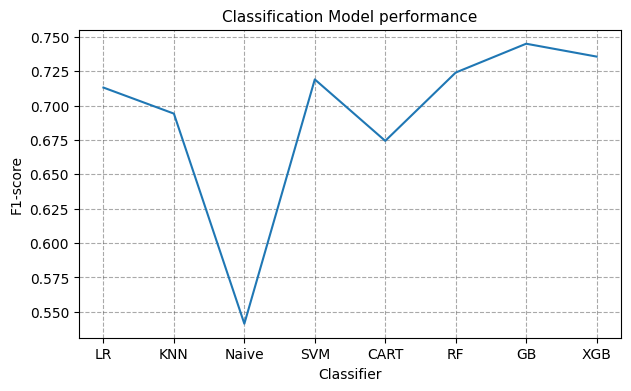

In [8]:
# Save results in dataframe
cw_df = pd.DataFrame(scores, columns=['Classifier', 'F1-score'])

# Model perfromance visualization
fig = plt.figure(figsize=(7, 4))
sns.lineplot(cw_df, x='Classifier', y='F1-score')
plt.grid(ls='--', color='#555', alpha=0.5)
plt.title("Classification Model performance", size=11);

- *Class weights improve the performance of the models, Along with tree-based classifier, Logisitic Regression, SVM perform very well.*
- *Gradient Boosting Classifier outperforms other classifier with highest f1-score 0.74.*

A higher feature importance score suggests that the particular feature has a greater impact on the model's decisions. 
* We'll use tree-based model such as Random Forest as they have their own built-in methods for calculating importance scores.
Let's find the most influential features in making predictions. 

In [9]:
clf = RandomForestClassifier(max_depth=3, class_weight=weights_dict, random_state=42)
clf.fit(X_train, y_train)
feature_score = pd.Series(clf.feature_importances_, name='f_score', index=X_train.columns).sort_values(ascending=False)
top_features = feature_score.head(15).index
top_features.tolist()

['age',
 'num_of_products',
 'age_label_41-55',
 'avg_credit_score_by_age',
 'age_young',
 'single_product',
 'age_label_proportion',
 'age_label_31-40',
 'age_label_18-30',
 'age_label_56-70',
 'is_active_member',
 'zero_balance',
 'balance',
 'geography_germany',
 'is_female']

To ensure, removing a feature does not negatively impact the model's accuracy, Examine the model's performance based on this top features using cross-validation.

In [10]:
# Store scores in dataframe
scores_df = pd.DataFrame(columns=['train-score', 'test-score', 'train-score-tf', 'test-score-tf'])

# define random forest model
clf = RandomForestClassifier(max_depth=3, class_weight=weights_dict, random_state=42)

# Cross-validation using all features
cv_scores = cross_validate(clf, 
                            X_train, 
                            y_train, 
                            scoring=('roc_auc', 'recall_macro', 'f1_macro'), 
                            cv=10, 
                            n_jobs=-1, 
                            return_train_score=True)


scores_df['train-score'] = [cv_scores['train_roc_auc'].mean(), 
                             cv_scores['train_recall_macro'].mean(),
                             cv_scores['train_f1_macro'].mean()]

scores_df['test-score'] = [cv_scores['test_roc_auc'].mean(), 
                             cv_scores['test_recall_macro'].mean(),
                             cv_scores['test_f1_macro'].mean()]


# Cross-validation with top features
cv_scores = cross_validate(clf, 
                            X_train[top_features], 
                            y_train, 
                            scoring=('roc_auc', 'recall_macro', 'f1_macro'), 
                            cv=10, 
                            n_jobs=-1, 
                            return_train_score=True)


scores_df['train-score-tf'] = [cv_scores['train_roc_auc'].mean(), 
                             cv_scores['train_recall_macro'].mean(),
                             cv_scores['train_f1_macro'].mean()]

scores_df['test-score-tf'] = [cv_scores['test_roc_auc'].mean(), 
                             cv_scores['test_recall_macro'].mean(),
                             cv_scores['test_f1_macro'].mean()]

scores_df.index = ['roc-auc', 'recall', 'f1-score']

In [11]:
scores_df

,train-score,test-score,train-score-tf,test-score-tf
roc-auc,0.820384,0.813373,0.823849,0.818716
recall,0.718751,0.716591,0.723722,0.721208
f1-score,0.667966,0.665647,0.671188,0.668841


Removal of features improves the performance of the model. so let's select the top features for further model selection.

In [12]:
# New datasets
x_train = X_train[top_features].copy()
x_valid = X_valid[top_features].copy()

### Model Optimization

Let's further evaluate the classifier model using GridSearch cross-validation method to find the optimal model that perform good on validation data.

For that, we are going to select classifier based on above cross-validation score, this includes gradient boosting, xgboosting, random forest, k-nearest, and logistic regression classification algorithms.

In [13]:
# Functions to evaluate the best model from search algorithm.

score_df = pd.DataFrame(columns=['model', 'fit-time',
                                'train-roc-auc', 
                                'train-precision',
                                'train-recall', 
                                'train-f1-score', 
                                'valid-roc-auc', 
                                'valid-precision', 
                                'valid-recall', 
                                'valid-f1-score'])

def search_score(y_true, y_preds_proba, threshold=0.5):
    # Convert predictions into 0 and 1 based on threshold
    y_preds = (y_preds_proba > threshold).astype(int)
    
    # Display confusion matrix
    cm = confusion_matrix(y_true, y_preds)
    
    # Precision, Recall, F1-Score
    precision, recall, f1score, support = precision_recall_fscore_support(y_true, y_preds, average='macro')
    return precision, recall, f1score, cm
    
def evaluate_search_model(search_model, clf_name, fit_time):
    # Fit the model on training data
    search_model.fit(x_train, y_train)
    
    # Make predictions
    y_train_preds_proba = search_model.predict_proba(x_train)[:, 1]
    y_valid_preds_proba = search_model.predict_proba(x_valid)[:, 1]

    train_roc = roc_auc_score(y_train, y_train_preds_proba)
    valid_roc = roc_auc_score(y_valid, y_valid_preds_proba)
    
    # Compute score
    train_precision, train_recall, train_f1score, train_cm= search_score(y_train, y_train_preds_proba)
    valid_precision, valid_recall, valid_f1score, valid_cm = search_score(y_valid, y_valid_preds_proba)

    
    clf_score = pd.DataFrame(data={'Training score': [train_roc, train_precision, train_recall, train_f1score],
                                  'Validation score': [valid_roc, valid_precision, valid_recall, valid_f1score]}, 
                           index=['ROC-AUC', 'Precision', 'Recall', 'F1-score'])
    
    score_df.loc[len(score_df)] = [clf_name, fit_time, train_roc, train_precision, train_recall, train_f1score, valid_roc, valid_precision, valid_recall, valid_f1score]


    valid_cm_df = pd.DataFrame(valid_cm, columns=['Predicted_0', 'Predicted_1'], index=['Actual_0', 'Actual_1'])
    
    return search_model, clf_score, valid_cm_df

### Gradient Boosting classifier

In [14]:
# Scoring function
def scoring_func(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:, 1])

# Define the model
gbm_clf = GradientBoostingClassifier(validation_fraction=0.2,
                                     max_features='sqrt',
                                     n_iter_no_change=30,
                                     random_state=42)

# Define parameters
param_grid = {
    'n_estimators' : [100, 300, 500, 800, 1200],
    'learning_rate': [0.01, 0.02, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample':[0.6, 0.8]
}

# Define search algorithm
gbm_search = GridSearchCV(gbm_clf,
                          param_grid,
                          scoring=scoring_func,
                          n_jobs=-1,
                          cv=StratifiedKFold(7, shuffle=True, random_state=42),
                          verbose=1,
                          return_train_score=True)

# Fit the search algorithm on training data
gbm_search = gbm_search.fit(x_train, y_train)

Fitting 7 folds for each of 120 candidates, totalling 840 fits


In [15]:
gbm_CVresults = pd.DataFrame(gbm_search.cv_results_).sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
gbm_CVresults = gbm_CVresults[['mean_fit_time', 'param_n_estimators', 'param_learning_rate', 'param_max_depth',
                                'param_subsample', 'mean_train_score', 'mean_test_score']]
gbm_CVresults.head()

,mean_fit_time,param_n_estimators,param_learning_rate,param_max_depth,param_subsample,mean_train_score,mean_test_score
0,2.859380,800,0.02,3,0.8,0.879542,0.864875
1,2.861949,1200,0.02,3,0.8,0.879542,0.864875
2,4.729217,800,0.01,5,0.6,0.895510,0.864771
3,4.757329,1200,0.01,5,0.6,0.895510,0.864771
4,2.844797,1200,0.02,3,0.6,0.879760,0.864718


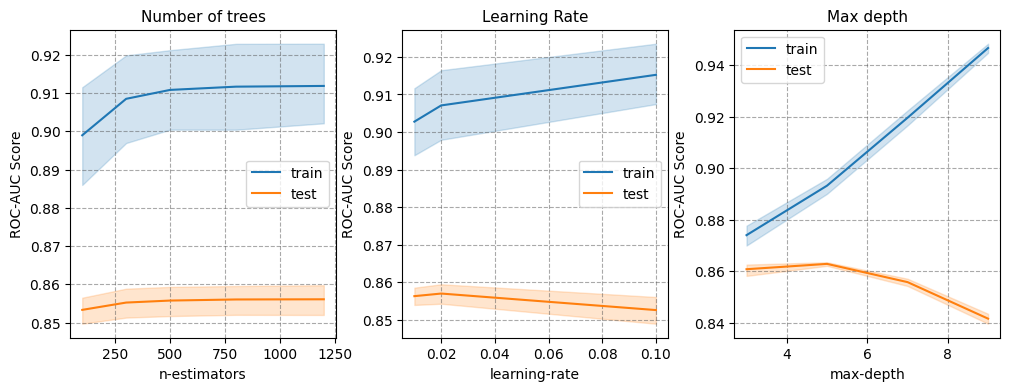

In [16]:
# Plot learning curves
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(wspace=0.25)

# plot
sns.lineplot(gbm_CVresults, x=f'param_n_estimators', y='mean_train_score', ax=ax1, label='train')
sns.lineplot(gbm_CVresults, x=f'param_n_estimators', y='mean_test_score', ax=ax1, label='test')

sns.lineplot(gbm_CVresults, x=f'param_learning_rate', y='mean_train_score', ax=ax2, label='train')
sns.lineplot(gbm_CVresults, x=f'param_learning_rate', y='mean_test_score', ax=ax2, label='test')

sns.lineplot(gbm_CVresults, x=f'param_max_depth', y='mean_train_score', ax=ax3, label='train')
sns.lineplot(gbm_CVresults, x=f'param_max_depth', y='mean_test_score', ax=ax3, label='test')

ax1.set_title("Number of trees", size=11)
ax2.set_title("Learning Rate", size=11)
ax3.set_title("Max depth", size=11)

ax1.set_xlabel('n-estimators')
ax2.set_xlabel('learning-rate')
ax3.set_xlabel('max-depth')

ax1.set_ylabel('ROC-AUC Score')
ax2.set_ylabel('ROC-AUC Score')
ax3.set_ylabel('ROC-AUC Score')

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5)
ax3.grid(ls='--', color='#555', alpha=0.5)

ax1.legend()
ax2.legend()
ax3.legend();

- *As parameter value increases the gap between roc-scores also increases indicating overfitting model.*
- *Next, evaluate model on validation data*

In [17]:
# Evaluate best model on validation data
gbm_model = gbm_search.best_estimator_
gbm_model, gbm_score, cm_df = evaluate_search_model(gbm_model, 'gbm', gbm_CVresults.loc[0, 'mean_fit_time'])
score_df

,model,fit-time,train-roc-auc,train-precision,train-recall,train-f1-score,valid-roc-auc,valid-precision,valid-recall,valid-f1-score
0,gbm,2.85938,0.875079,0.832965,0.725176,0.76009,0.857815,0.814231,0.710583,0.743493


In [18]:
print('Confusion Matrix')
cm_df

Confusion Matrix


,Predicted_0,Predicted_1
Actual_0,1532,61
Actual_1,220,187


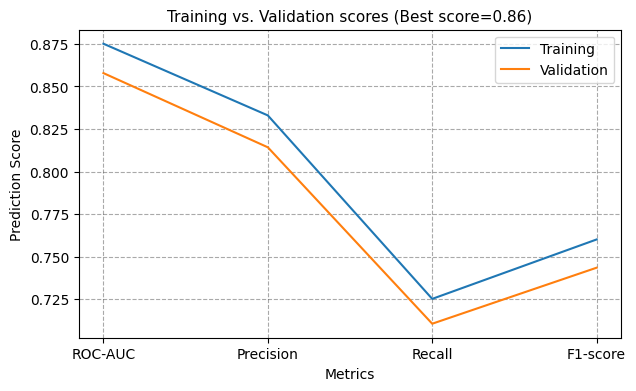

In [19]:
# plot scores
best_score = gbm_search.best_score_
plt.figure(figsize=(7, 4))

sns.lineplot(gbm_score, x=gbm_score.index, y='Training score', label='Training')
sns.lineplot(gbm_score, x=gbm_score.index, y='Validation score', label='Validation')

# Add labels
plt.xlabel('Metrics')
plt.ylabel('Prediction Score')
plt.title(f"Training vs. Validation scores (Best score={best_score:.2f})", size=11)

plt.grid(ls='--', color='#555', alpha=0.5)
plt.legend();

- *Gradient Boosting model seems to have good overall performance, especially in terms of ROC-AUC. However, lower recall indeicates that it might miss some positive cases.*
- *We are more interested in recall scores, as we dont wanna miss out any false negatives(actual positives), let's model evaluate further on percision-recall curve over different thresholds.*

In [20]:
# Make predictions using search best model
y_valid_preds_proba = gbm_model.predict_proba(x_valid)[:, 1]

In [21]:
# Precision-recall curve
precision, recall, threshold = precision_recall_curve(y_valid, y_valid_preds_proba)
pr_score = pd.DataFrame({'Threshold': threshold,
                         'Precision': precision[:-1],
                         'Recall': recall[:-1]})

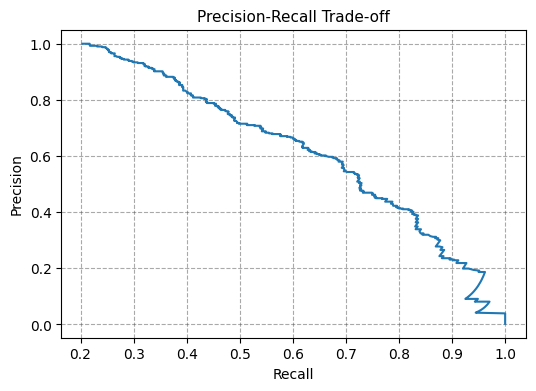

In [22]:
# Plot
plt.figure(figsize=(6, 4))
plt.plot(pr_score.Precision, pr_score.Recall)

# Add labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Trade-off", size=11)
plt.grid(ls='--', color='#555', alpha=0.5);

- *We can see trade-off between precision and recall as the recall increases the precision dreasease.*
- *Let's find optimal value based on high f1 score, as f1-score balances precision and recall.*

In [23]:
# Find the optimal value of threshold by calcualting f1 score.
pr_score = pr_score.assign(F1score = (2 * pr_score.Precision * pr_score.Recall) / (pr_score.Precision + pr_score.Recall)) 
pr_score.sort_values(by=['F1score'], ascending=False).head(3)

,Threshold,Precision,Recall,F1score
1079,0.368864,0.682720,0.592138,0.634211
1012,0.303924,0.617716,0.651106,0.633971
1015,0.305302,0.619718,0.648649,0.633854


- *It seems like 0.3 is good treshold values.*

In [24]:
# Scores at 0.3 threshold
precision, recall, f1score, class_report = search_score(y_valid, y_valid_preds_proba, 0.3)
print("At Threshold(0.3)")
print(f"Precison ==> {precision} \nRecall ==> {recall}\nF1score ==> {f1score}\n")

print("Classfication Report:\n", class_report)

At Threshold(0.3)
Precison ==> 0.761432350718065 
Recall ==> 0.7731360019495612
F1score ==> 0.7669752673280095

Classfication Report:
 [[1426  167]
 [ 142  265]]


In [25]:
# Save grid search gradient model
save_model('gbm_search_model', (gbm_search, gbm_model))

### XGBoost Classifier

In [26]:
# Define the model
xgb_clf = XGBClassifier(colsample_bytree=0.25,
                        random_state=42,
                        eval_metric='auc')

# Define parameters
param_grid = {
    'n_estimators' : [100, 500, 800, 1000, 1200, 1600],
    'learning_rate': [0.01, 0.02, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8]
}

# Define search algorithm
xgb_search = GridSearchCV(xgb_clf,
                          param_grid,
                          scoring=scoring_func,
                          n_jobs=-1, 
                          cv=StratifiedKFold(7, shuffle=True, random_state=42),
                          verbose=1,
                          return_train_score=True)

# Fit the search algorithm on training data
xgb_search = xgb_search.fit(x_train, y_train)

Fitting 7 folds for each of 144 candidates, totalling 1008 fits


In [27]:
xgb_CVresults = pd.DataFrame(xgb_search.cv_results_).sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
xgb_CVresults = xgb_CVresults[['mean_fit_time', 'param_n_estimators', 'param_learning_rate', 'param_max_depth', 
                               'param_subsample', 'mean_train_score', 'mean_test_score']]
xgb_CVresults.head()

,mean_fit_time,param_n_estimators,param_learning_rate,param_max_depth,param_subsample,mean_train_score,mean_test_score
0,1.849223,1200,0.02,3,0.8,0.885639,0.865622
1,1.555583,1000,0.02,3,0.8,0.883277,0.865596
2,1.247099,800,0.02,3,0.8,0.880447,0.865439
3,2.471235,1600,0.01,3,0.8,0.880222,0.865205
4,2.473904,1600,0.02,3,0.8,0.889468,0.864942


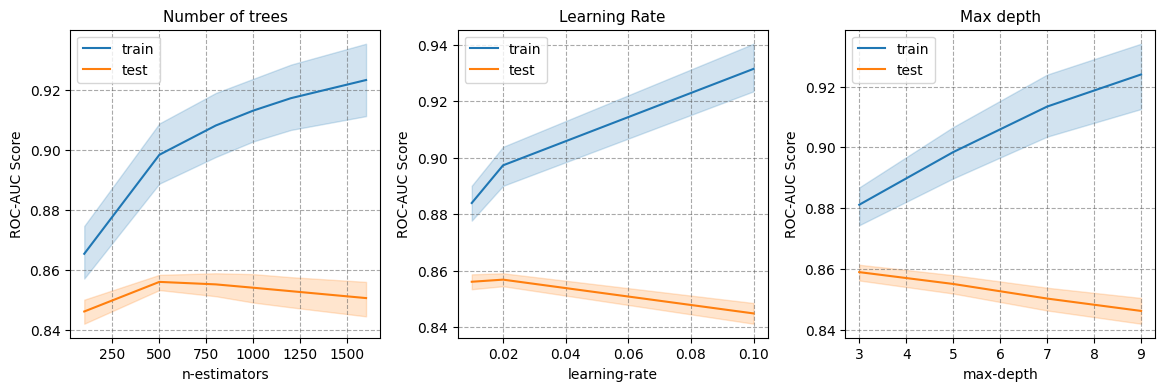

In [28]:
# Plot learning curves
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
fig.subplots_adjust(wspace=0.25)

# plot
sns.lineplot(xgb_CVresults, x='param_n_estimators', y='mean_train_score', ax=ax1, label='train')
sns.lineplot(xgb_CVresults, x='param_n_estimators', y='mean_test_score', ax=ax1, label='test')

sns.lineplot(xgb_CVresults, x='param_learning_rate', y='mean_train_score', ax=ax2, label='train')
sns.lineplot(xgb_CVresults, x='param_learning_rate', y='mean_test_score', ax=ax2, label='test')

sns.lineplot(xgb_CVresults, x='param_max_depth', y='mean_train_score', ax=ax3, label='train')
sns.lineplot(xgb_CVresults, x='param_max_depth', y='mean_test_score', ax=ax3, label='test')

ax1.set_title("Number of trees", size=11)
ax2.set_title("Learning Rate", size=11)
ax3.set_title("Max depth", size=11)

ax1.set_xlabel('n-estimators')
ax2.set_xlabel('learning-rate')
ax3.set_xlabel('max-depth')

ax1.set_ylabel('ROC-AUC Score')
ax2.set_ylabel('ROC-AUC Score')
ax3.set_ylabel('ROC-AUC Score')

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5)
ax3.grid(ls='--', color='#555', alpha=0.5)

ax1.legend()
ax2.legend()
ax3.legend();

In [29]:
# Evaluate best model on validation data
xgb_model = xgb_search.best_estimator_
xgb_model, xgb_score, xgb_cm_df = evaluate_search_model(xgb_model, 'xgb', xgb_CVresults.loc[0, 'mean_fit_time'])
score_df

,model,fit-time,train-roc-auc,train-precision,train-recall,train-f1-score,valid-roc-auc,valid-precision,valid-recall,valid-f1-score
0,gbm,2.859380,0.875079,0.832965,0.725176,0.760090,0.857815,0.814231,0.710583,0.743493
1,xgb,1.849223,0.883799,0.838257,0.725101,0.761152,0.856057,0.817368,0.711211,0.744691


In [30]:
print("Confusion Matrix")
xgb_cm_df

Confusion Matrix


,Predicted_0,Predicted_1
Actual_0,1534,59
Actual_1,220,187


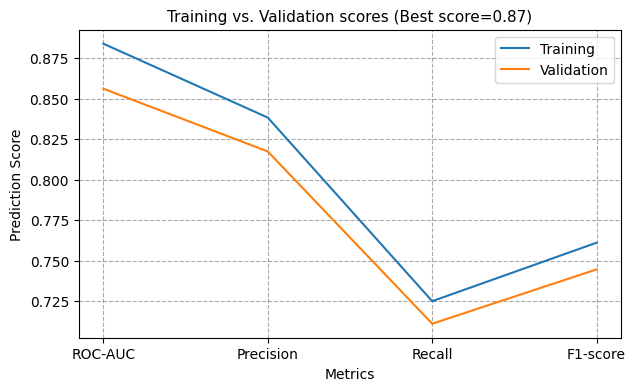

In [31]:
# plot scores
best_score = xgb_search.best_score_
plt.figure(figsize=(7, 4))

sns.lineplot(xgb_score, x=xgb_score.index, y='Training score', label='Training')
sns.lineplot(xgb_score, x=xgb_score.index, y='Validation score', label='Validation')

# Add labels
plt.xlabel('Metrics')
plt.ylabel('Prediction Score')
plt.title(f"Training vs. Validation scores (Best score={best_score:.2f})", size=11)

plt.grid(ls='--', color='#555', alpha=0.5)
plt.legend();

- *XGBoost model performance is very similar to Gradient Boosting.*
- *Overall performances was very good, especially in terms of ROC-AUC. However, recall scores is lower for XGBoost as well which might miss some positive cases.*
- *Let's evaluate the precision and recall with different threshold for XGBoost classifier as well.*

In [32]:
# Make predictions using search best model
y_valid_preds_proba = xgb_model.predict_proba(x_valid)[:, 1]

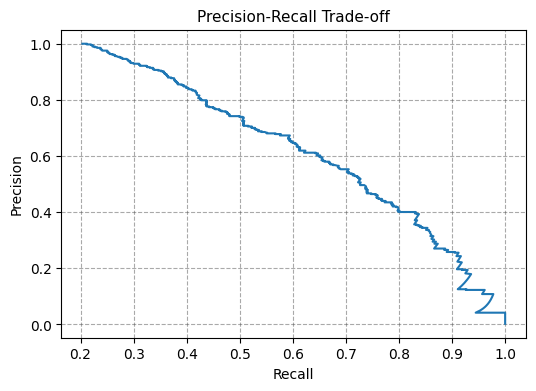

In [33]:
# Precision-recall curve
precision, recall, threshold = precision_recall_curve(y_valid, y_valid_preds_proba)
pr_score = pd.DataFrame({'Threshold': threshold,
                         'Precision': precision[:-1],
                         'Recall': recall[:-1]})

# Visualization
plt.figure(figsize=(6, 4))
plt.plot(pr_score.Precision, pr_score.Recall)

# Add labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Trade-off", size=11)
plt.grid(ls='--', color='#555', alpha=0.5);

In [34]:
# Find the optimal value of threshold by calcualting f1 score.
pr_score = pr_score.assign(F1score = (2 * pr_score.Precision * pr_score.Recall) / (pr_score.Precision + pr_score.Recall)) 
pr_score.sort_values(by=['F1score'], ascending=False).head(3)

,Threshold,Precision,Recall,F1score
1082,0.280032,0.594360,0.673219,0.631336
1083,0.280486,0.592593,0.668305,0.628176
1157,0.337900,0.647520,0.609337,0.627848


In [35]:
# Scores at 0.3 threshold
precision, recall, f1score, class_report = search_score(y_valid, y_valid_preds_proba, 0.3)
print("At Threshold(0.3)")
print(f"Precison ==> {precision} \nRecall ==> {recall}\nF1score ==> {f1score}\n")

print("Confusion Matrix:\n", class_report)

At Threshold(0.3)
Precison ==> 0.7562577727696864 
Recall ==> 0.767280377449869
F1score ==> 0.7614874728088171

Confusion Matrix:
 [[1423  170]
 [ 146  261]]


In [36]:
# Save grid search gradient model
save_model('xgb_search_model', (xgb_search, xgb_model))

### Random Forest Classifier

In [37]:
# Define the model
rf_clf = RandomForestClassifier(class_weight=weights_dict,
                                random_state=42)

# Define parameters
param_grid = {'criterion':['log_loss', 'entropy', 'gini'],
              'max_depth':[3, 5, 7, 9],
              'n_estimators' : [100, 500, 800, 1000, 1200, 1400, 1600],
              'max_samples':[0.6, 0.7, 0.8]}

# Define search algorithm
rf_search = GridSearchCV(rf_clf,
                         param_grid,
                         scoring=scoring_func,
                         cv=StratifiedKFold(7, shuffle=True, random_state=42),
                         n_jobs=-1,
                         verbose=1,
                         return_train_score=True)

# Fit the search algorithm on training data
rf_search = rf_search.fit(x_train, y_train)

Fitting 7 folds for each of 252 candidates, totalling 1764 fits


In [38]:
# Cross-validation Results
rf_CVresults = pd.DataFrame(rf_search.cv_results_).sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
rf_CVresults = rf_CVresults[['mean_fit_time', 'param_criterion', 'param_max_samples', 'param_max_depth', 
                             'param_n_estimators', 'mean_train_score', 'mean_test_score']]
rf_CVresults.head()

,mean_fit_time,param_criterion,param_max_samples,param_max_depth,param_n_estimators,mean_train_score,mean_test_score
0,0.606731,log_loss,0.6,7,100,0.888055,0.856266
1,0.616111,entropy,0.6,7,100,0.888055,0.856266
2,4.909730,entropy,0.6,7,800,0.889355,0.856229
3,4.731079,log_loss,0.6,7,800,0.889355,0.856229
4,5.965962,log_loss,0.6,7,1000,0.889393,0.856186


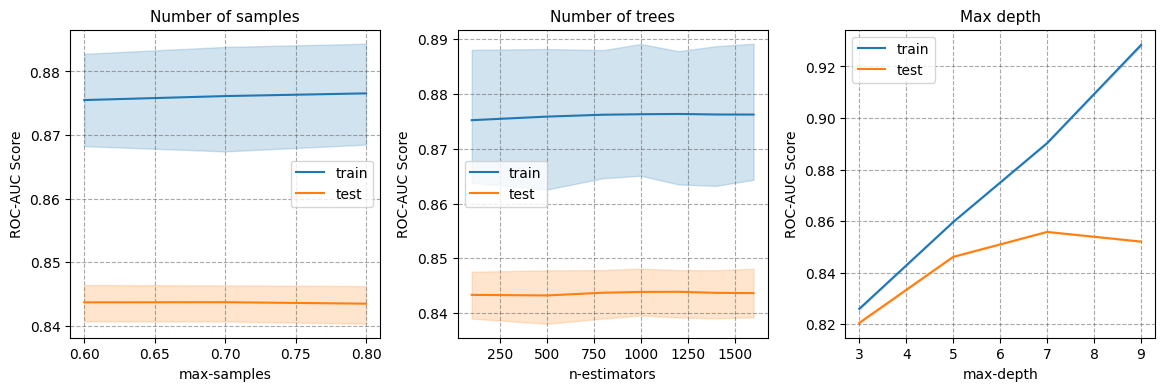

In [39]:
# Plot learning curves
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
fig.subplots_adjust(wspace=0.25)

# plot
sns.lineplot(rf_CVresults, x='param_max_samples', y='mean_train_score', ax=ax1, label='train')
sns.lineplot(rf_CVresults, x='param_max_samples', y='mean_test_score', ax=ax1, label='test')

sns.lineplot(rf_CVresults, x='param_n_estimators', y='mean_train_score', ax=ax2, label='train')
sns.lineplot(rf_CVresults, x='param_n_estimators', y='mean_test_score', ax=ax2, label='test')

sns.lineplot(rf_CVresults, x='param_max_depth', y='mean_train_score', ax=ax3, label='train')
sns.lineplot(rf_CVresults, x='param_max_depth', y='mean_test_score', ax=ax3, label='test')

ax1.set_title("Number of samples", size=11)
ax2.set_title("Number of trees", size=11)
ax3.set_title("Max depth", size=11)

ax1.set_xlabel('max-samples')
ax2.set_xlabel('n-estimators')
ax3.set_xlabel('max-depth')

ax1.set_ylabel('ROC-AUC Score')
ax2.set_ylabel('ROC-AUC Score')
ax3.set_ylabel('ROC-AUC Score')

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5)
ax3.grid(ls='--', color='#555', alpha=0.5)

ax1.legend()
ax2.legend()
ax3.legend();

- *From above plots, we can say there no such difference between training and test roc-auc score of random forest classifier for different values of max-samples and n-estimators.*
- *Although, large values of max-depth tends to overfit the model.*

In [40]:
# Evaluate best model on validation data
rf_model = rf_search.best_estimator_
rf_model, rf_score, rf_cm_df = evaluate_search_model(rf_model, 'rf', rf_CVresults.loc[0, 'mean_fit_time'])
score_df

,model,fit-time,train-roc-auc,train-precision,train-recall,train-f1-score,valid-roc-auc,valid-precision,valid-recall,valid-f1-score
0,gbm,2.859380,0.875079,0.832965,0.725176,0.760090,0.857815,0.814231,0.710583,0.743493
1,xgb,1.849223,0.883799,0.838257,0.725101,0.761152,0.856057,0.817368,0.711211,0.744691
2,rf,0.606731,0.885676,0.733346,0.794234,0.753178,0.850002,0.711496,0.765610,0.728944


In [41]:
print("Confusion Matrix")
rf_cm_df

Confusion Matrix


,Predicted_0,Predicted_1
Actual_0,1312,281
Actual_1,119,288


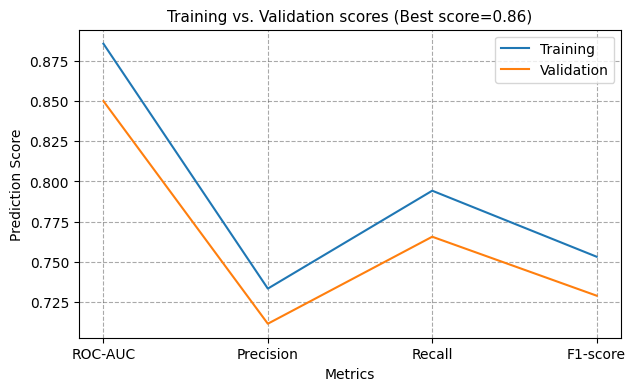

In [42]:
# plot scores
best_score = rf_search.best_score_
plt.figure(figsize=(7, 4))

sns.lineplot(rf_score, x=rf_score.index, y='Training score', label='Training')
sns.lineplot(rf_score, x=rf_score.index, y='Validation score', label='Validation')

# Add labels
plt.xlabel('Metrics')
plt.ylabel('Prediction Score')
plt.title(f"Training vs. Validation scores (Best score={best_score:.2f})", size=11)

plt.grid(ls='--', color='#555', alpha=0.5)
plt.legend();

- *The performance of Random Forest classifier is better than previous models.*
- *The model score high ROC-AUC 0.85 indicates good discriminatory power, with high f1score and Recall of 0.76 meaning 76% of all positive samples captures by model.*

In [43]:
# Make predictions using search best model
y_valid_preds_proba = rf_model.predict_proba(x_valid)[:, 1]

In [44]:
# Scores at 0.5 threshold
precision, recall, f1score, class_report = search_score(y_valid, y_valid_preds_proba, 0.5)
print("At Threshold(0.5)")
print(f"Precison ==> {precision} \nRecall ==> {recall}\nF1score ==> {f1score}\n")

print("Classfication Report:\n", class_report)

At Threshold(0.5)
Precison ==> 0.7114962560132836 
Recall ==> 0.765609985948969
F1score ==> 0.7289444010755486

Classfication Report:
 [[1312  281]
 [ 119  288]]


In [45]:
# Save grid search random forest model
save_model('rf_search_model', (rf_search, rf_model))

### K-Nearest Neighbors

In [46]:
# Define the model
knn = KNeighborsClassifier()

# Define parameters
param_grid = {'n_neighbors':[3, 5, 7, 9, 10, 15, 18, 21, 30]}

# Define search algorithm
knn_search = GridSearchCV(knn,
                         param_grid,
                         scoring=scoring_func,
                         cv=StratifiedKFold(7),
                         n_jobs=-1,
                         verbose=1,
                         return_train_score=True)

# Fit the search algorithm on training data
knn_search = knn_search.fit(x_train, y_train)

Fitting 7 folds for each of 9 candidates, totalling 63 fits


In [47]:
# Cross-validation Results
knn_CVresults = pd.DataFrame(knn_search.cv_results_).sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
knn_CVresults = knn_CVresults[['mean_fit_time', 'param_n_neighbors','mean_train_score', 'mean_test_score']]
knn_CVresults.head()

,mean_fit_time,param_n_neighbors,mean_train_score,mean_test_score
0,0.056283,30,0.877402,0.842406
1,0.052854,21,0.883643,0.837831
2,0.057140,18,0.886298,0.834236
3,0.057712,15,0.889685,0.829200
4,0.058141,10,0.902794,0.821522


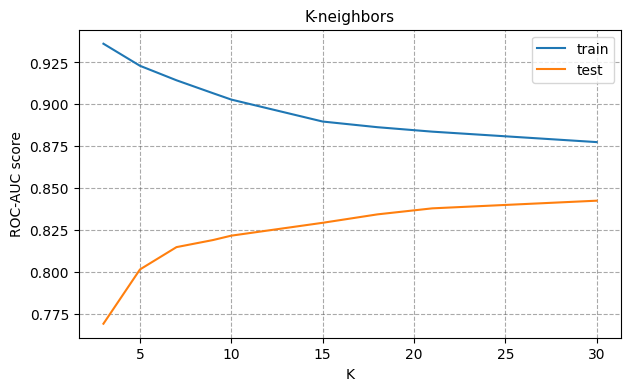

In [48]:
# plot scores
plt.figure(figsize=(7, 4))

sns.lineplot(knn_CVresults, x='param_n_neighbors', y='mean_train_score', label='train')
sns.lineplot(knn_CVresults, x='param_n_neighbors', y='mean_test_score', label='test')

# Add labels
plt.xlabel('K')
plt.ylabel('ROC-AUC score')
plt.title("K-neighbors", size=11)

plt.grid(ls='--', color='#555', alpha=0.5)
plt.legend();

- *large neighbors values improves the model predictive powers. let's further evaluate the model based on precision, recall, and f1 scores.*

In [49]:
# Evaluate best model from grid search on validation data
knn_model = knn_search.best_estimator_
knn_model, knn_score, knn_cm_df = evaluate_search_model(knn_model, 'knn', knn_CVresults.loc[0, 'mean_fit_time'])
score_df

,model,fit-time,train-roc-auc,train-precision,train-recall,train-f1-score,valid-roc-auc,valid-precision,valid-recall,valid-f1-score
0,gbm,2.859380,0.875079,0.832965,0.725176,0.760090,0.857815,0.814231,0.710583,0.743493
1,xgb,1.849223,0.883799,0.838257,0.725101,0.761152,0.856057,0.817368,0.711211,0.744691
2,rf,0.606731,0.885676,0.733346,0.794234,0.753178,0.850002,0.711496,0.765610,0.728944
3,knn,0.056283,0.877314,0.821182,0.697091,0.732529,0.846718,0.810581,0.700155,0.733489


In [50]:
print("Confusion maxtirx:\n")
knn_cm_df

Confusion maxtirx:



,Predicted_0,Predicted_1
Actual_0,1534,59
Actual_1,229,178


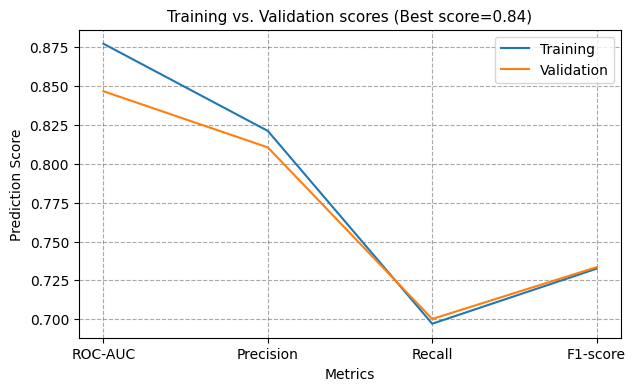

In [51]:
# plot knn scores
best_score = knn_search.best_score_
plt.figure(figsize=(7, 4))

sns.lineplot(knn_score, x=knn_score.index, y='Training score', label='Training')
sns.lineplot(knn_score, x=knn_score.index, y='Validation score', label='Validation')

# Add labels
plt.xlabel('Metrics')
plt.ylabel('Prediction Score')
plt.title(f"Training vs. Validation scores (Best score={best_score:.2f})", size=11)

plt.grid(ls='--', color='#555', alpha=0.5)
plt.legend();

- *Overall performance of K-nearest neighbors model seems good.*
- *It produce highly precise model, leaving huge gap between Precision and Recall score indicating missing actual positive class.*
- *Since, we are intreseted in high recall score, Let us compare models precision and recall score with different threshold. To find the optimal model that has high recall.*

In [52]:
# Make predictions using search best model
y_valid_preds_proba = knn_model.predict_proba(x_valid)[:, 1]

In [53]:
precision, recall, threshold = precision_recall_curve(y_valid, y_valid_preds_proba)
pr_score = pd.DataFrame(data={'Threshold': threshold, 
                              'Precision': precision[:-1],
                              'Recall': recall[:-1]})

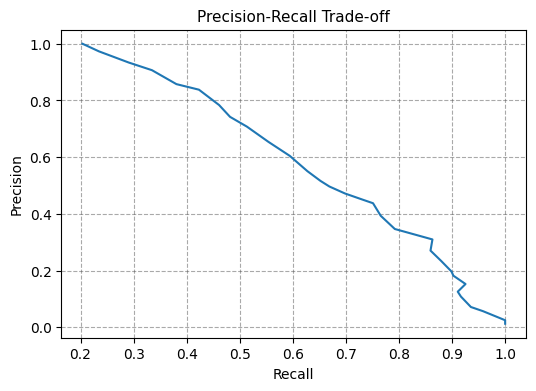

In [54]:
# Plot precision-recall trade-off curve
plt.figure(figsize=(6, 4))
plt.plot(pr_score.Precision, pr_score.Recall)

# Add labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Trade-off", size=11)
plt.grid(ls='--', color='#555', alpha=0.5);

In [55]:
# To Find the optimal value of threshold for knn model, calcualte f1 score.
pr_score = pr_score.assign(F1score = (2 * pr_score.Precision * pr_score.Recall) / (pr_score.Precision + pr_score.Recall)) 
pr_score.sort_values(by=['F1score'], ascending=False).head(3)

,Threshold,Precision,Recall,F1score
9,0.300000,0.554167,0.653563,0.599775
10,0.333333,0.594203,0.604423,0.599269
8,0.266667,0.513369,0.707617,0.595041


- *0.2 or 0.3 seems to be a good threshold for knn model.*

In [56]:
# Threshold - 0.2
precision, recall, f1score, cm = search_score(y_valid, y_valid_preds_proba, 0.2)
print(f"At, 0.2 threshold ::\nPrecision ==> {precision}\nRecall ==> {recall}\nF1-score ==> {f1score}\n")
print("Confusion Matrix::\n", cm)
print("--"*10)

# Threshold - 0.3
precision, recall, f1score, cm = search_score(y_valid, y_valid_preds_proba, 0.3)
print(f"At, 0.3 threshold ::\nPrecision ==> {precision}\nRecall ==> {recall}\nF1-score ==> {f1score}\n")
print("Confusion Matrix::\n", cm)

At, 0.2 threshold ::
Precision ==> 0.7025919098215644
Recall ==> 0.7689985825579047
F1-score ==> 0.7195814328997497

Confusion Matrix::
 [[1268  325]
 [ 105  302]]
--------------------
At, 0.3 threshold ::
Precision ==> 0.7463448288466108
Recall ==> 0.7494806054128088
F1-score ==> 0.7478887599383746

Confusion Matrix::
 [[1425  168]
 [ 161  246]]


- *At threshold 0.2, model has high recall score, with large gap between f1 score and precision.*
- *We are going to select threshold 0.3 as it has high recall with compartively higher f1score and precision score.*

In [57]:
# Save knn model
save_model('knn_search_model', (knn_search, knn_model))

### Logistic Regression

In [58]:
# Define the model
lr_clf = LogisticRegression(penalty='l2', 
                         solver='newton-cholesky', 
                         class_weight=weights_dict,
                         random_state=42)

# Define parameters
param_grid = {'max_iter':[100, 1000],
              'C': [0.001, 0.01, 0.1, 1, 10]}

# Define search algorithm
lr_search = GridSearchCV(lr_clf,
                         param_grid,
                         scoring=scoring_func,
                         cv=StratifiedKFold(7),
                         n_jobs=-1,
                         verbose=1,
                         return_train_score=True)

# Fit the search algorithm on training data
lr_search = lr_search.fit(x_train, y_train)

Fitting 7 folds for each of 10 candidates, totalling 70 fits


In [59]:
lr_CVresults = pd.DataFrame(lr_search.cv_results_).sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
lr_CVresults = lr_CVresults[['mean_fit_time', 'param_max_iter', 'param_C', 'mean_train_score', 'mean_test_score']]
lr_CVresults.head()

,mean_fit_time,param_max_iter,param_C,mean_train_score,mean_test_score
0,0.040348,100,1.0,0.847625,0.844898
1,0.036289,1000,1.0,0.847625,0.844898
2,0.035869,1000,10.0,0.847716,0.844897
3,0.038713,100,10.0,0.847716,0.844897
4,0.034017,100,0.1,0.844253,0.841864


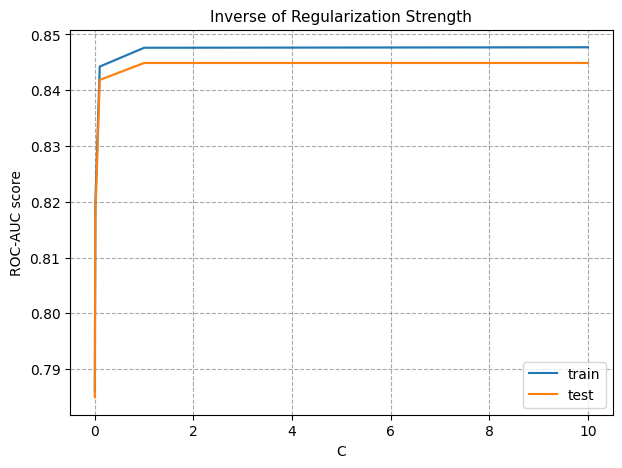

In [60]:
# plot scores
plt.figure(figsize=(6, 4))

sns.lineplot(lr_CVresults, x='param_C', y='mean_train_score', label='train')
sns.lineplot(lr_CVresults, x='param_C', y='mean_test_score', label='test')

# Add labels
plt.xlabel('C')
plt.ylabel('ROC-AUC score')
plt.title("Inverse of Regularization Strength", size=11)

plt.grid(ls='--', color='#555', alpha=0.5)
plt.legend();

In [61]:
# Evaluation of best model from search on validation data
lr_model = lr_search.best_estimator_
lr_model, lr_score, lr_cm = evaluate_search_model(lr_model, 'lr', lr_CVresults.loc[0, 'mean_fit_time'])
score_df

,model,fit-time,train-roc-auc,train-precision,train-recall,train-f1-score,valid-roc-auc,valid-precision,valid-recall,valid-f1-score
0,gbm,2.859380,0.875079,0.832965,0.725176,0.760090,0.857815,0.814231,0.710583,0.743493
1,xgb,1.849223,0.883799,0.838257,0.725101,0.761152,0.856057,0.817368,0.711211,0.744691
2,rf,0.606731,0.885676,0.733346,0.794234,0.753178,0.850002,0.711496,0.765610,0.728944
3,knn,0.056283,0.877314,0.821182,0.697091,0.732529,0.846718,0.810581,0.700155,0.733489
4,lr,0.040348,0.847491,0.701168,0.768310,0.717837,0.836169,0.697227,0.766720,0.713078


In [62]:
lr_cm

,Predicted_0,Predicted_1
Actual_0,1249,344
Actual_1,102,305


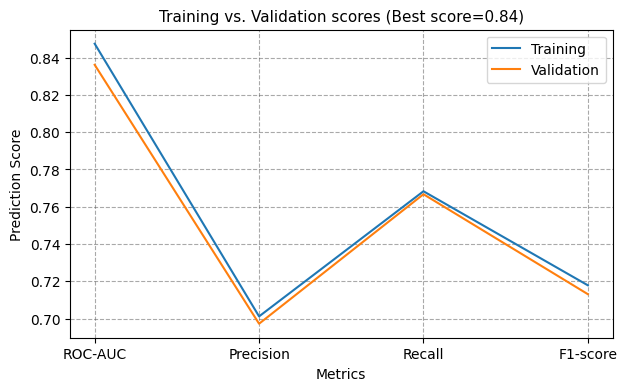

In [63]:
# plot logistic regression scores
best_score = lr_search.best_score_
plt.figure(figsize=(7, 4))

sns.lineplot(lr_score, x=lr_score.index, y='Training score', label='Training')
sns.lineplot(lr_score, x=lr_score.index, y='Validation score', label='Validation')

# Add labels
plt.xlabel('Metrics')
plt.ylabel('Prediction Score')
plt.title(f"Training vs. Validation scores (Best score={best_score:.2f})", size=11)

plt.grid(ls='--', color='#555', alpha=0.5)
plt.legend();

- *Performance of logisitic Regression seems good. it is one of the highest recall model.*

In [64]:
# Make prediction using search best model
y_valid_preds_proba = lr_model.predict_proba(x_valid)[:, 1]

In [65]:
# Threshold - 0.5
precision, recall, f1score, cm = search_score(y_valid, y_valid_preds_proba, 0.5)
print(f"At, 0.5 threshold ::\nPrecision ==> {precision}\nRecall ==> {recall}\nF1-score ==> {f1score}\n")
print("Confusion Matrix::\n", cm)

At, 0.5 threshold ::
Precision ==> 0.6972270725673729
Recall ==> 0.7667204955340549
F1-score ==> 0.7130784749670619

Confusion Matrix::
 [[1249  344]
 [ 102  305]]


- *Threshold 0.5 looks good as it has high recall and f1-score.*
- *Let us select 0.5 for further evaluation for logitic Regression model*

In [66]:
# Save model
save_model('log_search_model', (lr_search, lr_model))

In [67]:
score_df

,model,fit-time,train-roc-auc,train-precision,train-recall,train-f1-score,valid-roc-auc,valid-precision,valid-recall,valid-f1-score
0,gbm,2.859380,0.875079,0.832965,0.725176,0.760090,0.857815,0.814231,0.710583,0.743493
1,xgb,1.849223,0.883799,0.838257,0.725101,0.761152,0.856057,0.817368,0.711211,0.744691
2,rf,0.606731,0.885676,0.733346,0.794234,0.753178,0.850002,0.711496,0.765610,0.728944
3,knn,0.056283,0.877314,0.821182,0.697091,0.732529,0.846718,0.810581,0.700155,0.733489
4,lr,0.040348,0.847491,0.701168,0.768310,0.717837,0.836169,0.697227,0.766720,0.713078


### Ensembles : Gradient boosting, Random Forest, K-Neighbors, Logistic Regression

In [68]:
# Evaluate the ensemble on validation data.
lr_y_preds = lr_model.predict_proba(x_valid)[:, 1]
rf_y_preds = rf_model.predict_proba(x_valid)[:, 1]
knn_y_preds = knn_model.predict_proba(x_valid)[:, 1]
xgb_y_preds= xgb_model.predict_proba(x_valid)[:, 1]

# Select the most common prediction
y_preds = (lr_y_preds + rf_y_preds + knn_y_preds + xgb_y_preds) / 4

# Compute scores at threshold 0.4
roc_score = roc_auc_score(y_valid, y_preds)
precision, recall, f1score, cm = search_score(y_valid, y_preds, 0.4)

In [69]:
print(f"ROC-AUC score ==> {roc_score:.2f}" )
print(f"Precision ==> {precision:.2f}\nRecall ==> {recall:.2f}")
print(f"F1-score ==> {f1score:.2f}\nConfusion Matrix ::\n{cm}")

ROC-AUC score ==> 0.85
Precision ==> 0.73
Recall ==> 0.77
F1-score ==> 0.75
Confusion Matrix ::
[[1357  236]
 [ 125  282]]
